In [ ]:
"""
this pipeline needs to be able to detect if a person is horizontal and if so is the persons head facing to the left or right vertically

based on that observation we can make the decision which value we should choose for detecting the face

1. input the image and then return in prompt if horizontal and if so if left or right facing

2. extract result from prompt 

3. based on result return the value 0 or 90 or 270
"""

In [18]:
!pip install litellm python-dotenv opencv-python

  Attempting uninstall: httpx
    Found existing installation: httpx 0.28.1
    Uninstalling httpx-0.28.1:
      Successfully uninstalled httpx-0.28.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aider-chat 0.59.1 requires aiohttp==3.10.5, but you have aiohttp 3.11.11 which is incompatible.
aider-chat 0.59.1 requires anyio==4.6.0, but you have anyio 4.8.0 which is incompatible.
aider-chat 0.59.1 requires beautifulsoup4==4.12.3, but you have beautifulsoup4 4.13.3 which is incompatible.
aider-chat 0.59.1 requires certifi==2024.8.30, but you have certifi 2025.1.31 which is incompatible.
aider-chat 0.59.1 requires charset-normalizer==3.3.2, but you have charset-normalizer 3.4.1 which is incompatible.
aider-chat 0.59.1 requires click==8.1.7, but you have click 8.1.8 which is incompatible.
aider-chat 0.59.1 requires filelock==3.16.1, but you have filelock 3.17.0 w

In [19]:
import os
import cv2
from litellm import completion
import base64
from dotenv import load_dotenv
import json

load_dotenv()

os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

/Users/maxhager/.virtualenvs/base/lib/python3.11/site-packages/pydantic/_internal/_config.py:345: UserWarning: Valid config keys have changed in V2:
* 'fields' has been removed
  warnings.warn(message, UserWarning)


In [92]:
#define image path
image_path = "examples/10.jpeg"

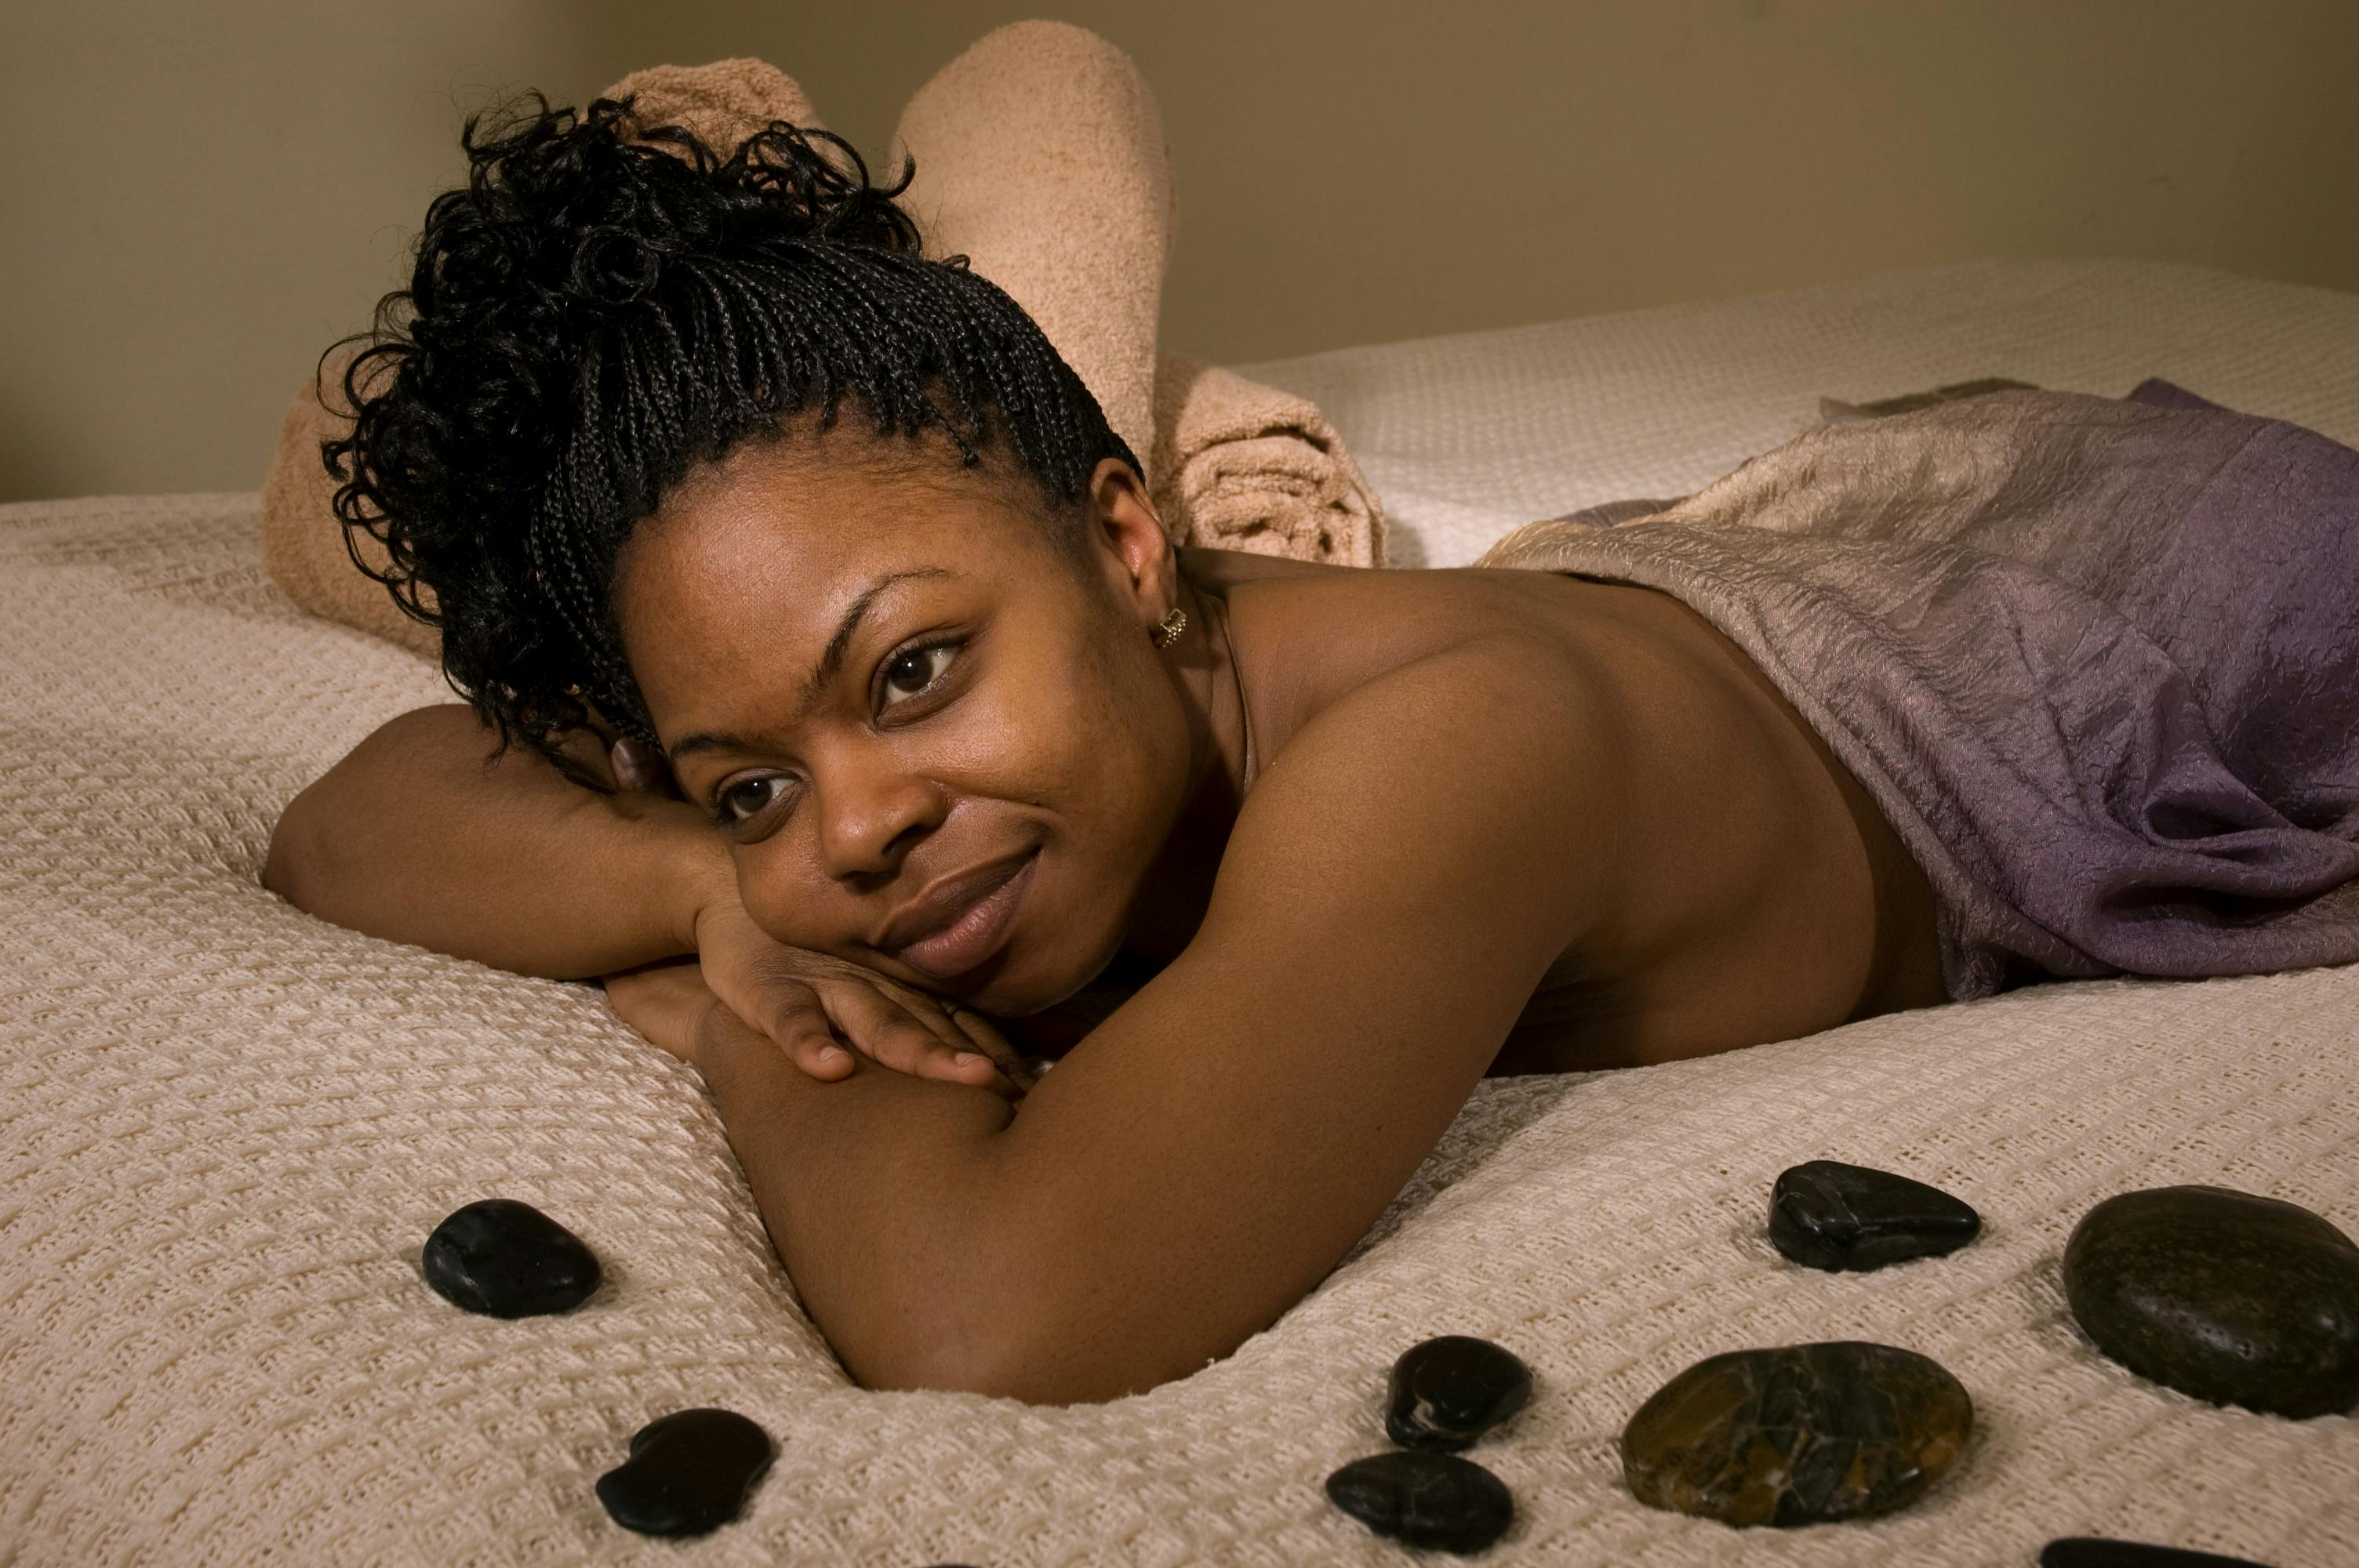

In [93]:
from IPython.display import Image, display

# Display the image
display(Image(image_path))

In [100]:
def get_alignment_of_faces(vision_frame) -> str:
	#!only temporarly for testing in prod the vision frame will be no path
	vision_frame = cv2.imread(vision_frame)

	# Convert frame to PNG in memory and encode to base64
	_, buffer = cv2.imencode('.png', vision_frame)
	base64_image = base64.b64encode(buffer).decode('utf-8')

	prompt="""
	Analyze the image and determine if the person is positioned horizontally or vertically. 

	Based on your observations, classify the person's position as either "horizontal" or "vertical" and keep your response to a minimum really briefly.
	"""

	# Make API call to vision model
	response = completion(
		model="gpt-4o-mini",
		messages=[
			{
				"role": "user",
				"content": [
					{
						"type": "text",
						"text": prompt
					},
					{
						"type": "image_url",
						"image_url": {
							"url": f"data:image/jpeg;base64,{base64_image}"
						}
					}
				]
			}
		],
	)
	return response.choices[0].message.content

In [101]:
value=get_alignment_of_faces(image_path)

In [102]:
print(value)

The person is positioned horizontally.


In [104]:
#extract the result from the response
def extract_result(response: str) -> str:
	"""
	this function should extract horizontal left - 90 or right - 270 or nothing - 0
	"""
	prompt = f"""
	You are processing the output from an image orientation detection system. Extract ONLY the orientation value based on these rules:
	- If the detection result clearly indicates a person in a horizontal position: return 1
	- If the detection result clearly indicates a person in a vertical position: return 2
	- For any unclear result, no person detected, or ambiguous response: return 0

	Here is the detection result to analyze:
	{response}

	Respond with ONLY a JSON object containing a single key "value" with value 1, 2, or 0.
	"""
	response = completion(
    	model = "gpt-4o", 
		response_format={ "type": "json_object" },
    	messages=[{ "content": prompt,"role": "user"}],
		temperature=0.0
	)
	response_json = json.loads(response.choices[0].message.content)
	#how to make sure that the model really only responds with one value ie 90 or 270 or 0?
	return response_json["value"]

In [105]:
final_value=extract_result(value)

In [106]:
print(final_value)

1


In [ ]:
"""
what can i do with this pipeline now? i can integrate it into the facefusion pipeline
"""